In [1]:
import sys
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# To get functions to plot the band structure and hamiltonian
sys.path.append("../../../")
from periodiclas.tools.util import LASdata
sns.set()

In [2]:
dpi = 500

plt.rcParams.update({
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.labelsize': 28,
    'figure.dpi': dpi,
    'axes.grid': True,
    'grid.linestyle': '--',
    'figure.figsize':(16,12),
    'axes.titlesize':24
})

# Fig 3B

In [3]:
# BNL* Reference values
BNLIP = -5.87
BNLEA =  -2.60

In [4]:
def get_homo_band_dft(pklfile):
    with open(pklfile, "rb") as f:
        data = pickle.load(f)
    homo_e, homo_k = data['homo_e'], data['homo_k']
    return  homo_e, homo_k

def get_lumo_band_dft(pklfile):
    with open(pklfile, "rb") as f:
        data = pickle.load(f)
    lumo_e, lumo_k = data['lumo_e'], data['lumo_k']
    return lumo_e, lumo_k

get_homo = get_homo_band_dft
get_lumo = get_lumo_band_dft

In [5]:
def shift_band_edge(homo_e, lumo_e):
    ip = np.argmax(homo_e)
    ea = np.argmin(lumo_e)
    
    firsthalf = homo_e[ip:]
    
    assert firsthalf.shape[0] == homo_e.shape[0] // 2 + 1, "Size mismatch in reflection logic"

    # Band edge shift with reflection
    homo_e_shifted = np.concatenate((homo_e[ip:], homo_e[ip:-1][::-1]))
    lumo_e_shifted = np.concatenate((lumo_e[ea:], lumo_e[ea:-1][::-1]))
    
    return homo_e_shifted, lumo_e_shifted

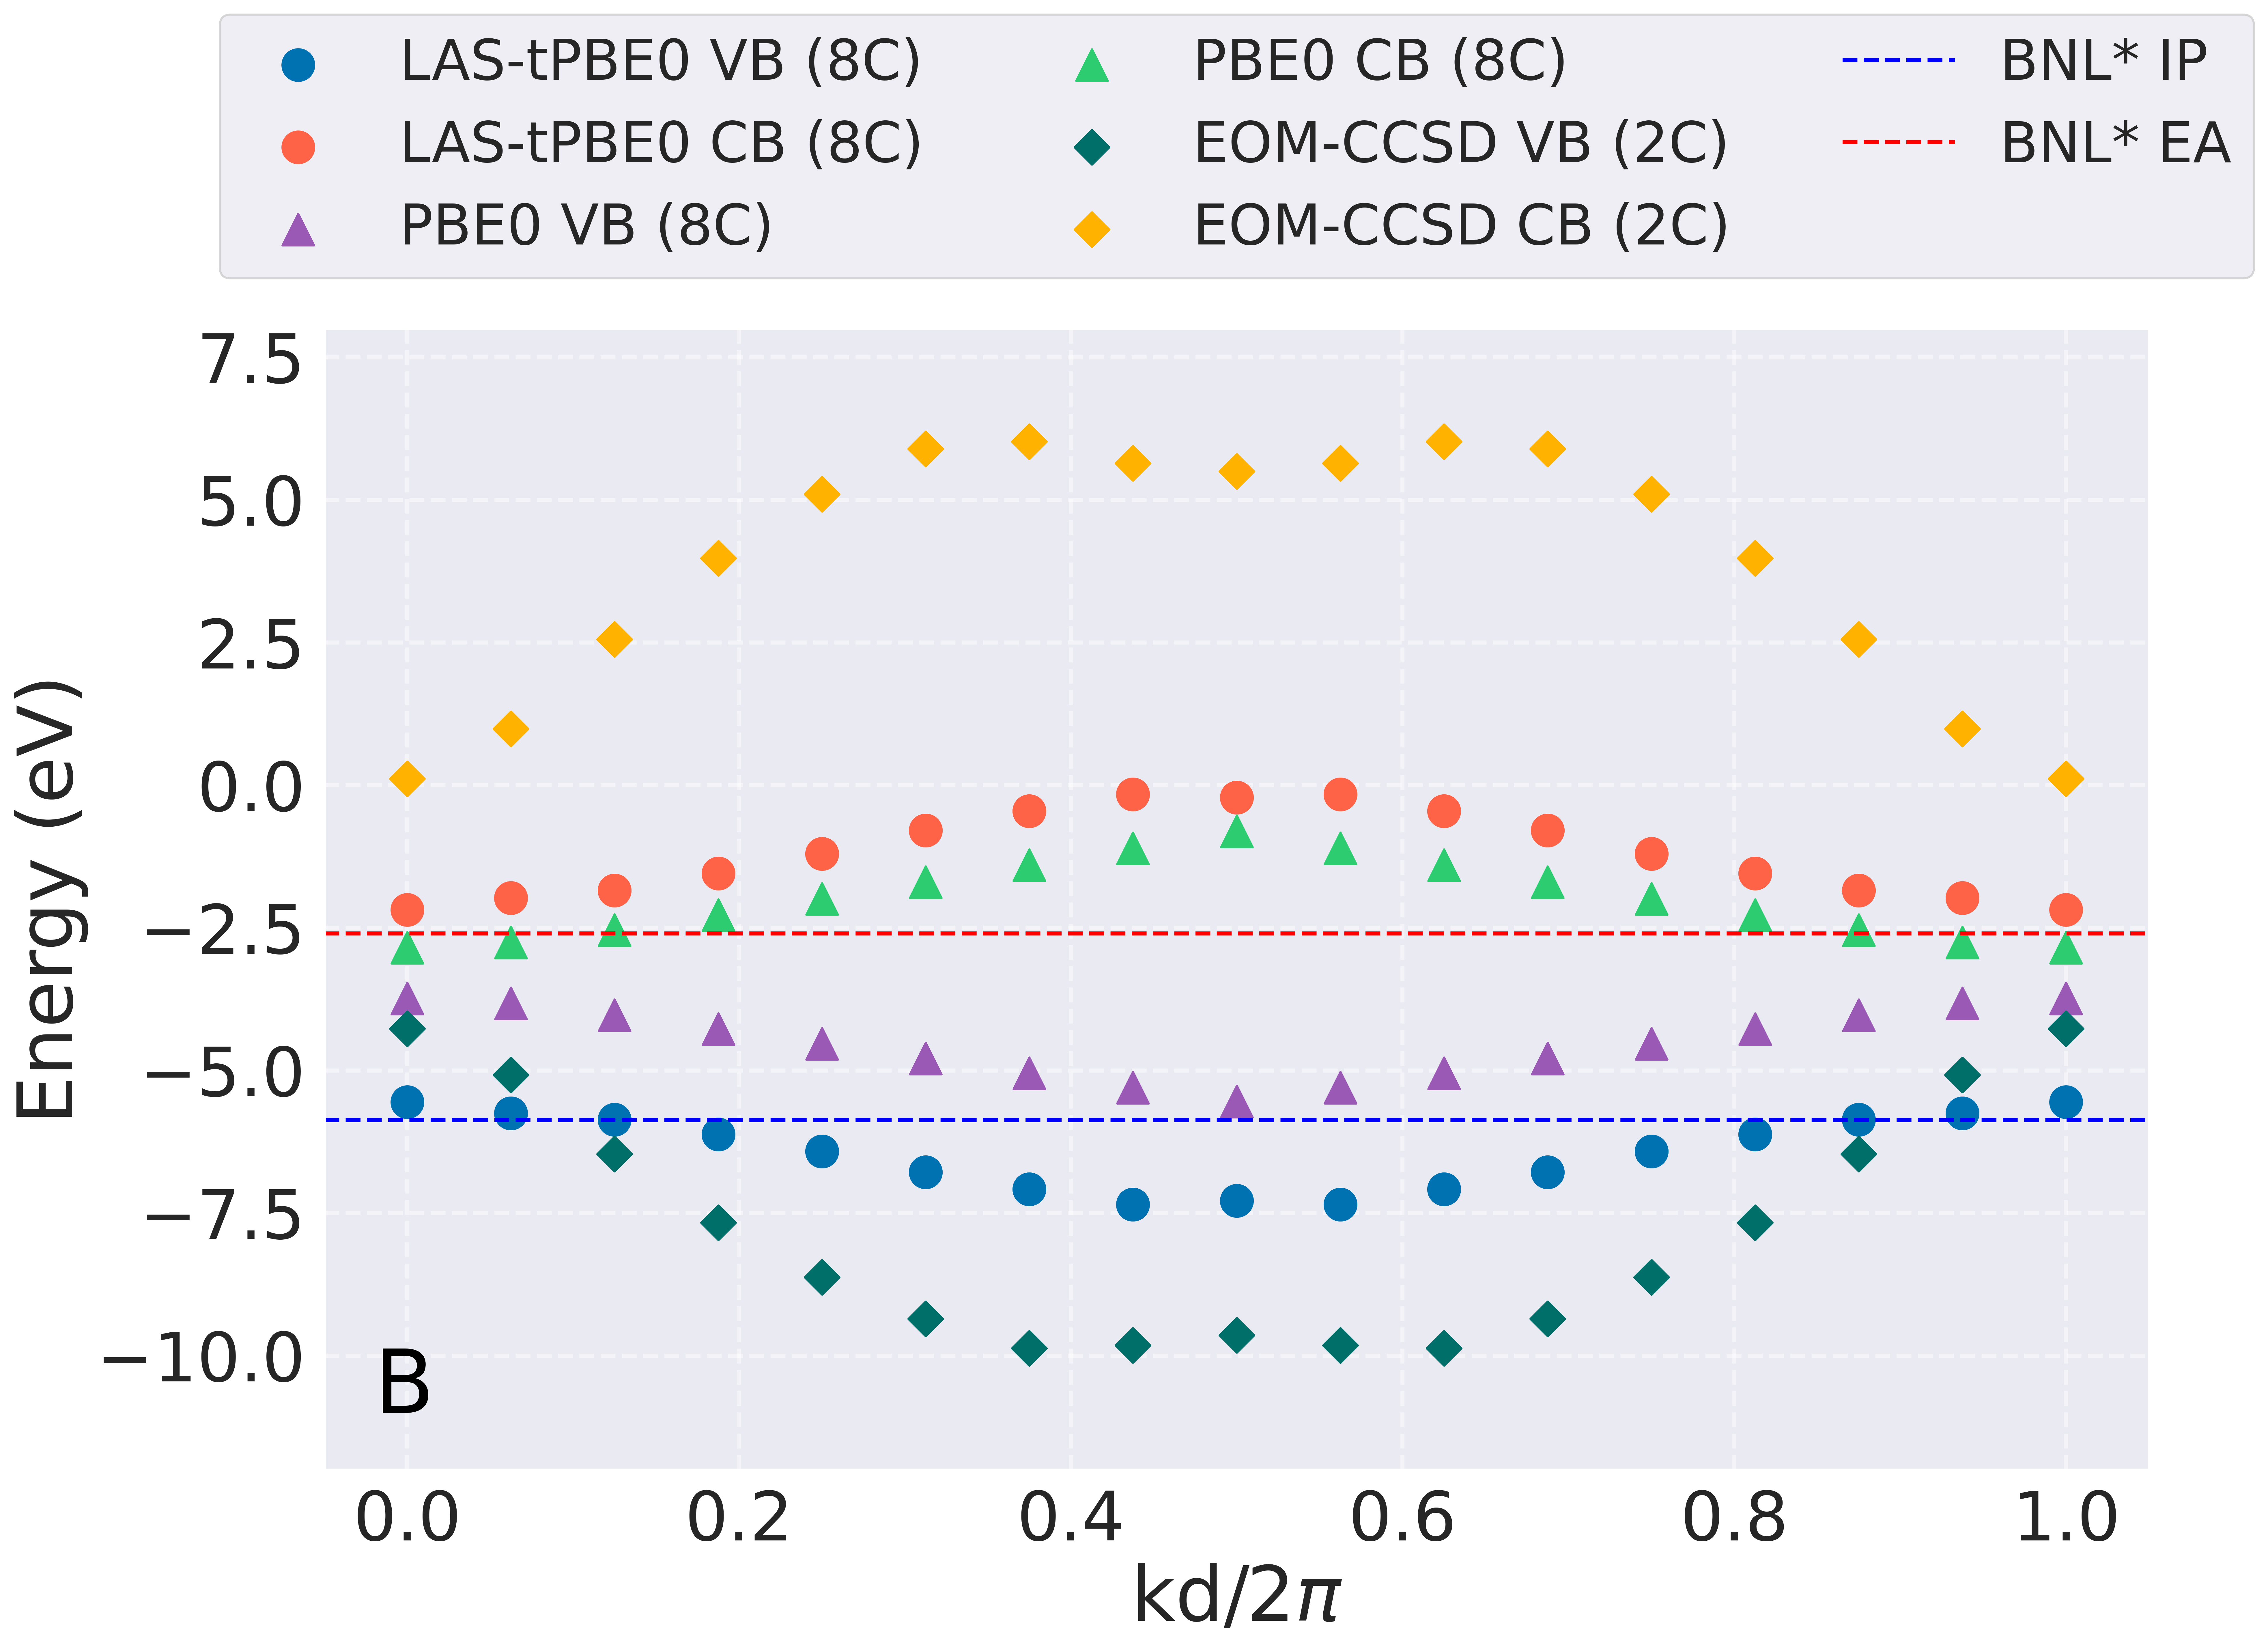

In [6]:
plt.figure()

# LAS-Band Gap
pklfile = './PAChain.8.128.pkl'
lasdata = LASdata(pkl_fn=pklfile, pct_pdft=0.75)
homo_e, homo_k = lasdata.get_homo()
lumo_e, lumo_k = lasdata.get_lumo()
plt.scatter(homo_k, homo_e, label="LAS-tPBE0 VB (8C)", color='#0072B2', marker='o',  s=250)
plt.scatter(lumo_k, lumo_e, label="LAS-tPBE0 CB (8C)", color='#FF6347', marker='o',  s=250)

# PBE0 Band GAP # Placeholder
pklfile = './PAChain.PBE.8.pkl'
homo_e, homo_k = get_homo(pklfile)
lumo_e, lumo_k = get_lumo(pklfile)
#homo_e, lumo_e = shift_band_edge(homo_e, lumo_e)
plt.scatter(homo_k, homo_e, label="PBE0 VB (8C)", color='#9B59B6', marker='^',  s=250)  
plt.scatter(lumo_k, lumo_e, label="PBE0 CB (8C)", color='#2ECC71', marker='^',  s=250)

# EOM-CCSD Band Gap
pklfile = './PAChain.2.16.pkl'
with open(pklfile, "rb") as f:
        data = pickle.load(f)

homo_e =  -27.21139 * data['eip']
lumo_e =   27.21139 * data['ea']

# For Gamma point
homo_e = np.append(homo_e, homo_e[0])
lumo_e = np.append(lumo_e, lumo_e[0])
homo_e, lumo_e = shift_band_edge(homo_e, lumo_e)
kpts = homo_k
plt.scatter(kpts, homo_e, label="EOM-CCSD VB (2C)", color='#006F6A', marker='D',  s=150)
plt.scatter(kpts, lumo_e,  label="EOM-CCSD CB (2C)", color='#FFB300', marker='D',  s=150)

plt.axhline(y=BNLIP, color='blue', linestyle='--', linewidth=2, label='BNL* IP')
plt.axhline(y=BNLEA, color='red', linestyle='--', linewidth=2, label='BNL* EA')

plt.xlabel("kd/2$\pi$", fontsize=38)
plt.ylabel("Energy (eV)", fontsize=38)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.ylim(-12, 8)
plt.grid(True, which='both', linestyle='--', linewidth=2, alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3,frameon=True, fontsize=28)
plt.tight_layout()

plt.annotate("B",(-0.02, -11),c='black',size=44)
plt.savefig('PALAStPBE0andPBEBandGap.pdf', dpi=dpi)